In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('default')


from ipywidgets import interact
import os,sys
# sys.addaudithook
rpath = os.getcwd()
sys.path.insert(0,"../")
# import utils

import dimred ### library of dimension reduction

In [25]:
from dimred.data.loader import LoadOne
from dimred.models.linear.transform import Kurtosis
from dimred.models.linear.transform import co_variance,co_kurtosis
from dimred.data.preprocess import MinMaxScalar,ZeroMeanScalar
# dimred.
from dimred.data.preprocess import scaleStd,scaleMax,scaleAvg,Scalar
from dimred.tester.plotting import plot_embedding


In [3]:
loader = LoadOne()

data = loader.getData()


## Dim reduction

In [27]:
slr = Scalar()

In [12]:
loader.flist[99]

'autoignition.9.9000E-06.field.mpi'

In [29]:
X = data[100]
# scl = Scalar(MinMaxScalar)
slr.fit(x)
xscaled = slr.transform(x) #scaleMax(X)

clf = Kurtosis()


NameError: name 'x' is not defined

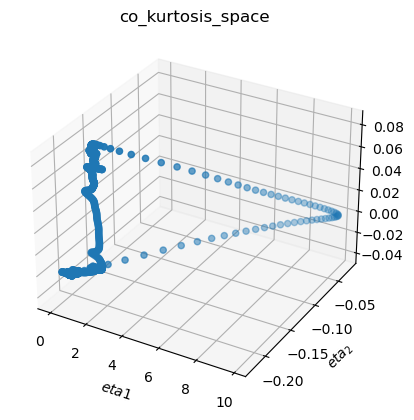

In [14]:

clf.fit(X,moment=co_kurtosis)
xr = clf.transform(X)

plot_embedding(xr,titler="co_kurtosis_space")

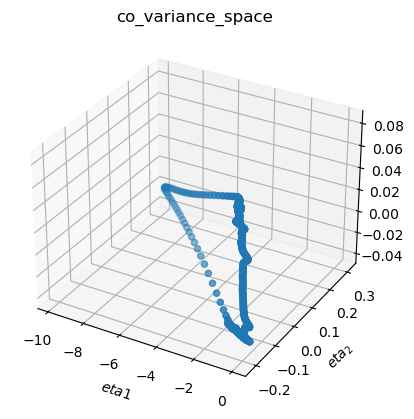

In [15]:
clf.fit(X,moment=co_variance)
xr = clf.transform(X)

plot_embedding(xr,titler="co_variance_space")

In [16]:
xold = X.copy()
xnew = clf.transform2(X)

Xnew is transformed data

Xold is original data

## Source Term comparison 

In [12]:
xnew.shape

(1024, 17)

In [13]:
xold.shape

(1024, 17)

In [1]:
## ToDo add cantera calculation on xnew and xold

## ToDo add cantera calculation on xnew and xold

In [17]:
import cantera as ct
gas = ct.Solution('cantera-module/COH2.cti')

In [18]:
ref_array = np.ones(14) #reference values required to multiplied to mpi data for conversion into the SI units

temp_ref = 120
press_ref = 1.41837E+05

ref_array[12] = temp_ref
ref_array[13] = press_ref

In [19]:
reactRates_old = np.zeros(shape=(1024,29)) # array to store reaction rates of 29 reactions
prodRates_old = np.zeros(shape=(1024,12))  # array to store production/consumption rates of the 12 species

In [24]:
sample[:14]

array([8.37850116e-03, 1.32995535e-01, 9.14915044e-07, 4.70382245e-07,
       7.58174691e-06, 1.91949425e-07, 7.15510185e-06, 2.55528982e-08,
       9.08368087e-02, 3.35233834e-06, 3.17815952e-09, 6.87861579e-04,
       4.99063114e+01, 0.00000000e+00])

In [22]:
gas()


  gas:

       temperature   49.281 K
          pressure   0.66744 Pa
           density   3.2761e-05 kg/m^3
  mean mol. weight   20.112 kg/kmol
   phase of matter   gas

                          1 kg             1 kmol     
                     ---------------   ---------------
          enthalpy       -1.8904e+06       -3.8019e+07  J
   internal energy       -1.9107e+06       -3.8429e+07  J
           entropy             11632        2.3394e+05  J/K
    Gibbs function       -2.4636e+06       -4.9548e+07  J
 heat capacity c_p            1368.1             27517  J/K
 heat capacity c_v            954.75             19202  J/K

                      mass frac. Y      mole frac. X     chem. pot. / RT
                     ---------------   ---------------   ---------------
                H2          0.035972           0.35887           -39.783
                O2             0.571            0.3589           -48.725
                 O         3.928e-06        4.9379e-06            555.8

In [20]:
for i in range(1024):                                  #iterating over all grid points
#     print(i)                                            
    sample = xold[i,:14]*ref_array                 #converting into the SI units
    gas.Y = sample[:12]                                #setting up the mass fraction of the species
    gas.TP = sample[12:14]                             #setting up the temperature and pressure of gas
    prodRates_old[i,:] = gas.net_production_rates      #calculating production/consumption rates
    reactRates_old[i,:] = gas.net_rates_of_progress    #calculating reaction rates

CanteraError: 
***********************************************************************
CanteraError thrown by Phase::setDensity:
density must be positive. density = 0.0
***********************************************************************


In [21]:
err = (np.sum((xnew-xold)**2,axis=0))**0.5

err

array([1.01839167e-02, 1.36542239e-01, 1.14153271e-02, 7.56310602e-03,
       5.22880535e-02, 1.06360013e-03, 1.30984156e-03, 3.18396893e-05,
       9.65960925e-02, 5.72728926e-02, 9.27767114e-06, 2.62612515e-01,
       4.42629971e-03, 8.11911430e-02, 3.27014698e-03, 0.00000000e+00,
       0.00000000e+00])

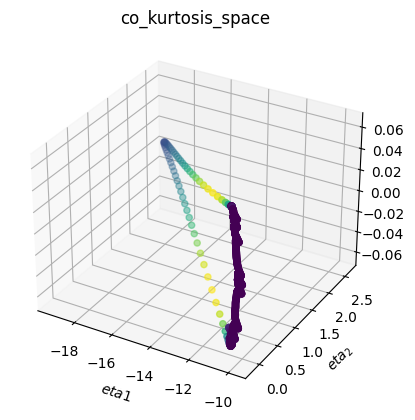

In [ ]:

clf.fit(X,moment=co_kurtosis)
xr = clf.transform(X)

plot_embedding(xr,color_spec=X[:,10],titler="co_kurtosis_space")

In [14]:
xold.shape

(1024, 17)

##

## Create Error analysis